# Проект «Отток клиентов из банка»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Описание данных](#Описание-данных)
1. [Чтение и предобработка данных](#Чтение-и-предобработка-данных)
1. [Исследование задачи](#Исследование-задачи)
    - [Исследование без учёта дизбаланса](#Исследуем-модель-без-учёта-дизбаланса)
    - [Исследование c учётом дизбаланса](#Исследуем-модель-с-учётом-дизбаланса)
1. [Тестирование модели](#Тестирование-модели)
1. [Общие выводы](#Общие-выводы)

## Описание проекта

[к навигации](#Навигация)

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры.


## Описание данных

[к навигации](#Навигация)

**Признаки**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**
- `Exited` — факт ухода клиента

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from sklearn.metrics import (f1_score, roc_auc_score, classification_report,
                            ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



In [2]:
RANDOM_STATE = 1629

- __Настройка стилей и форматов__

In [9]:
pd.set_option('display.float_format', '{:,.3f}'.format)
sns.set_theme()

## Чтение и предобработка данных

In [24]:
data = pd.read_csv('Churn.csv')

In [11]:
display(data.info())
display(data.head())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,"101,348.880",1
1,2,15647311,Hill,608,Spain,Female,41,1.000,"83,807.860",1,0,1,"112,542.580",0
2,3,15619304,Onio,502,France,Female,42,8.000,"159,660.800",3,1,0,"113,931.570",1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,"93,826.630",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,"125,510.820",1,1,1,"79,084.100",0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.000","10,000.000","10,000.000","10,000.000","9,091.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000"
mean,"5,000.500","15,690,940.569",650.529,38.922,4.998,"76,485.889",1.530,0.706,0.515,"100,090.240",0.204
std,"2,886.896","71,936.186",96.653,10.488,2.895,"62,397.405",0.582,0.456,0.500,"57,510.493",0.403
min,1.000,"15,565,701.000",350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,"2,500.750","15,628,528.250",584.000,32.000,2.000,0.000,1.000,0.000,0.000,"51,002.110",0.000
50%,"5,000.500","15,690,738.000",652.000,37.000,5.000,"97,198.540",1.000,1.000,1.000,"100,193.915",0.000
75%,"7,500.250","15,753,233.750",718.000,44.000,7.000,"127,644.240",2.000,1.000,1.000,"149,388.247",0.000
max,"10,000.000","15,815,690.000",850.000,92.000,10.000,"250,898.090",4.000,1.000,1.000,"199,992.480",1.000


In [25]:
data = data.rename(columns={
    'RowNumber': 'row_number',
    'CustomerId': 'customer_id',
    'Surname': 'surname',
    'CreditScore': 'credit_score',
    'Geography': 'geography',
    'Gender': 'gender',
    'Age': 'age',
    'Tenure': 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'num_of_products',
    'HasCrCard': 'has_cr_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited',
})
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,"101,348.880",1
1,2,15647311,Hill,608,Spain,Female,41,1.000,"83,807.860",1,0,1,"112,542.580",0
2,3,15619304,Onio,502,France,Female,42,8.000,"159,660.800",3,1,0,"113,931.570",1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,"93,826.630",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,"125,510.820",1,1,1,"79,084.100",0


Выбросим столбцы, что не могут быть признаками для обучения, т.е. `row_number`, `surname`, 
`customer_id`.

In [26]:
data = data.drop(columns=['row_number', 'surname', 'customer_id'])

Есть пропуски в признаке `tenure`. А RandomForestClassifier не умеет их обрабатывать. Заменим их на `-1`.

In [27]:
data['tenure'].isna().sum()

np.int64(909)

In [28]:
data['tenure'] = data['tenure'].fillna(-1)
data['tenure'].isna().sum()

np.int64(0)

Категориальные признаки закодируем через OHE.

In [29]:
data = pd.get_dummies(data, columns=['geography', 'gender'], drop_first=True, dtype='int')
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.000,0.000,1,1,1,"101,348.880",1,0,0,0
1,608,41,1.000,"83,807.860",1,0,1,"112,542.580",0,0,1,0
2,502,42,8.000,"159,660.800",3,1,0,"113,931.570",1,0,0,0
3,699,39,1.000,0.000,2,0,0,"93,826.630",0,0,0,0
4,850,43,2.000,"125,510.820",1,1,1,"79,084.100",0,0,1,0


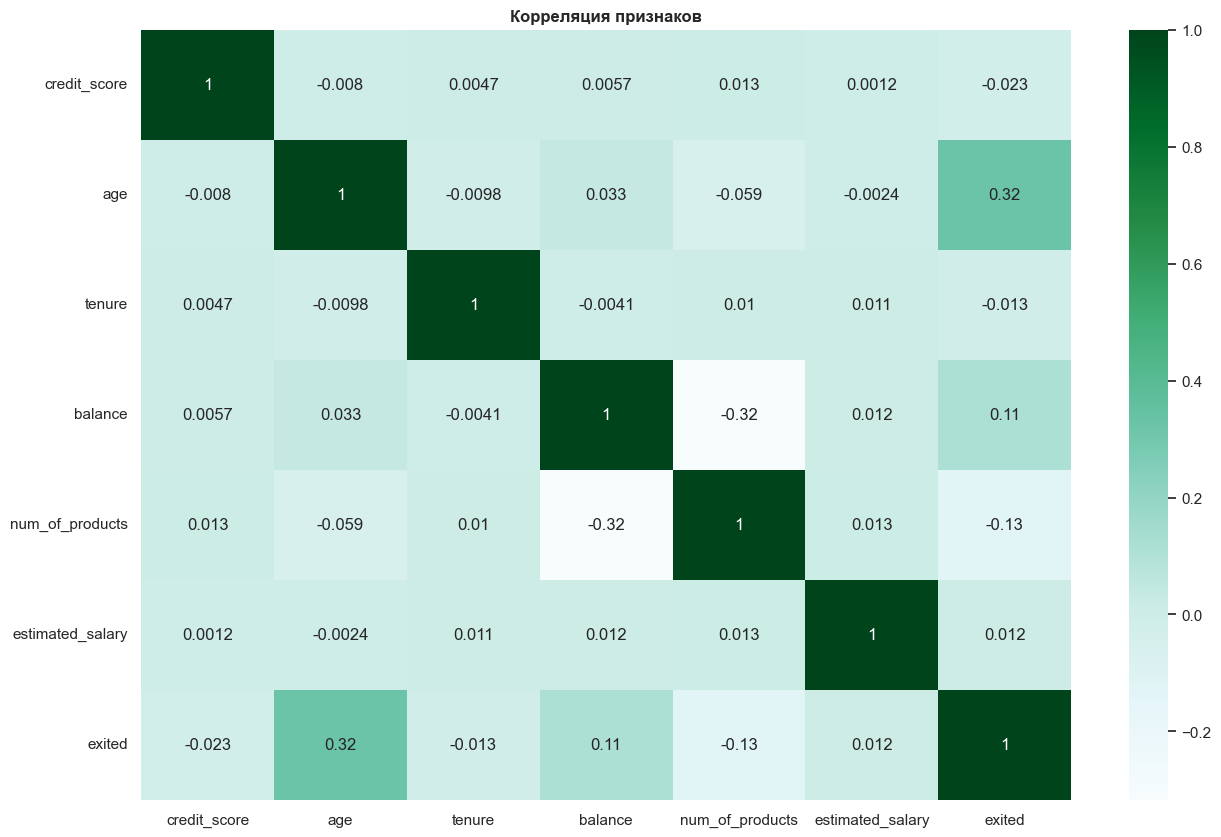

In [34]:
list_numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', 'exited'] 

# Построим тепловую карту корреляции
plt.figure(figsize=(15, 10))
plt.title('Корреляция признаков', weight='bold')
sns.heatmap(data[list_numeric].corr(method='spearman'), annot=True, cmap='BuGn')
plt.show()

Явной зависимости не наблюдается, но наибольшая корреляция прослеживается между колонками `age` и `exited`, a также `num_of_products` и `balance`

## Исследование-задачи

[к навигации](#Навигация)

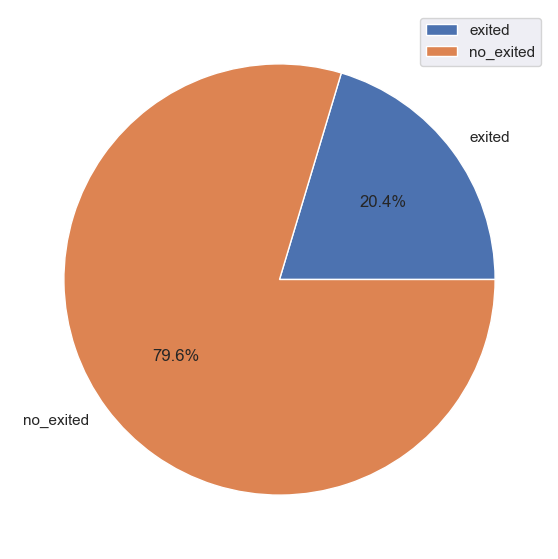

In [36]:
exited_size = (data['exited'] == 1).sum()
no_exited_size = (data['exited'] == 0).sum()

fig, ax = plt.subplots(figsize=(7, 7))

ax.pie([exited_size, no_exited_size], labels=['exited', 'no_exited'], autopct='%1.1f%%')
ax.legend();

### ___Исследуем модель без учёта дизбаланса___

In [38]:
y = data['exited']
X = data.drop('exited', axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y
) 

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_test
) 

In [42]:
# выведем сведения о разбивке данных
print(f'Данные разбиты в соотношении: '
      f'{len(X_train) / len(X):.1f}:'
      f'{len(X_valid) / len(X):.1f}:'
      f'{len(X_test) / len(X):.1f}\n')

# выведем пропорции классов целевого признака
print(f'Пропорция классов целевого признака (target) в генеральной совокупности: {sum(y == 0) / sum(y == 1):.2f}')
print(f'Пропорция классов в тренировочной выборке (target_train): {sum(y_train == 0) / sum(y_train == 1):.2f}')
print(f'Пропорция классов в валидационной выборке (target_valid): {sum(y_valid == 0) / sum(y_valid == 1):.2f}')
print(f'Пропорция классов в тестовой выборке (target_test): {sum(y_test == 0) / sum(y_test == 1):.2f}')

Данные разбиты в соотношении: 0.6:0.2:0.2

Пропорция классов целевого признака (target) в генеральной совокупности: 3.91
Пропорция классов в тренировочной выборке (target_train): 3.91
Пропорция классов в валидационной выборке (target_valid): 3.91
Пропорция классов в тестовой выборке (target_test): 3.90


В результате получили три набора данных:
1. Обучающий (на нём будем производить обучение моделей)
2. Валидационный (используется для проверки качества модели)
3. Тестовый (для оценки готовой модели)

Данные распределены равномерно (одинаковая пропорция нулей и единиц в целевом признаке всех выборок). Теперь мы готовы обучать, проверять и тестировать столько моделей машинного обучения, сколько будет необходимо для наших данных.

- __Модель решающего дерева__

In [46]:
best_depth = None
best_f1 = -1
best_auc = None

for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_prob = model.predict_proba(X_valid)[:, 1]

    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred_prob)

    print(f'глубина\t{depth},\tf1 {f1:.3},\tauc {auc:.3}')

    if best_f1 < f1:
        best_f1 = f1
        best_depth = depth
        best_auc = auc

print(f'Лучшая глубина\t{best_depth},\tf1 {best_f1:.3},\tauc {best_auc:.3}')

глубина	1,	f1 0.0,	auc 0.697
глубина	2,	f1 0.506,	auc 0.749
глубина	3,	f1 0.376,	auc 0.804
глубина	4,	f1 0.52,	auc 0.826
глубина	5,	f1 0.578,	auc 0.841
глубина	6,	f1 0.57,	auc 0.833
глубина	7,	f1 0.561,	auc 0.827
глубина	8,	f1 0.536,	auc 0.819
глубина	9,	f1 0.545,	auc 0.804
глубина	10,	f1 0.55,	auc 0.791
глубина	11,	f1 0.522,	auc 0.76
глубина	12,	f1 0.512,	auc 0.726
глубина	13,	f1 0.536,	auc 0.716
глубина	14,	f1 0.503,	auc 0.699
глубина	15,	f1 0.523,	auc 0.701
глубина	16,	f1 0.493,	auc 0.688
глубина	17,	f1 0.505,	auc 0.697
глубина	18,	f1 0.496,	auc 0.686
глубина	19,	f1 0.505,	auc 0.69
Лучшая глубина	5,	f1 0.578,	auc 0.841


- __Случайного леса__

In [51]:
best_depth = None
best_f1 = -1
best_auc = None
for est in range(10, 51, 10):
    for depth in range(2, 15):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est,  n_jobs=-1, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
    
        f1 = f1_score(y_valid, y_pred)
        auc = roc_auc_score(y_valid, y_pred_prob)
    
        print(f'глубина\t{depth}, кол-во деревьев\t{est}, \tf1 {f1:.3},\tauc {auc:.3}')
    
        if best_f1 < f1:
            best_f1 = f1
            best_depth = depth
            best_auc = auc

print(f'Лучшая глубина\t{best_depth}, кол-во деревьев {est}, \tf1 {best_f1:.3},\tauc {best_auc:.3}')

глубина	2, кол-во деревьев	10, 	f1 0.0146,	auc 0.796
глубина	3, кол-во деревьев	10, 	f1 0.116,	auc 0.831
глубина	4, кол-во деревьев	10, 	f1 0.312,	auc 0.826
глубина	5, кол-во деревьев	10, 	f1 0.439,	auc 0.845
глубина	6, кол-во деревьев	10, 	f1 0.483,	auc 0.849
глубина	7, кол-во деревьев	10, 	f1 0.514,	auc 0.856
глубина	8, кол-во деревьев	10, 	f1 0.489,	auc 0.856
глубина	9, кол-во деревьев	10, 	f1 0.548,	auc 0.861
глубина	10, кол-во деревьев	10, 	f1 0.554,	auc 0.851
глубина	11, кол-во деревьев	10, 	f1 0.538,	auc 0.851
глубина	12, кол-во деревьев	10, 	f1 0.534,	auc 0.831
глубина	13, кол-во деревьев	10, 	f1 0.515,	auc 0.828
глубина	14, кол-во деревьев	10, 	f1 0.567,	auc 0.837
глубина	2, кол-во деревьев	20, 	f1 0.0619,	auc 0.807
глубина	3, кол-во деревьев	20, 	f1 0.162,	auc 0.843
глубина	4, кол-во деревьев	20, 	f1 0.37,	auc 0.838
глубина	5, кол-во деревьев	20, 	f1 0.474,	auc 0.847
глубина	6, кол-во деревьев	20, 	f1 0.51,	auc 0.855
глубина	7, кол-во деревьев	20, 	f1 0.524,	auc 0.861
глубина

- Лучший f1-score получается у модели на DecisionTreeClassifier с глубиной деревьев 5.
- Однако разница между лучшим RandomForestClassifier и DecisionTreeClassifier небольшая

### ___Исследуем модель с учётом дизбаланса___

In [54]:
%%time 
grid_search = GridSearchCV(
    RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
    param_grid={
        'max_depth': list(range(2, 20)),
        'n_estimators': list(range(10, 51, 10))
    },
    scoring='f1',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.25,
        random_state=RANDOM_STATE
    )
)
grid_search.fit(X_train, y_train)

CPU times: total: 6.38 s
Wall time: 44.5 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1629, test_size=0.25,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1629),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='f1')

In [55]:
grid_search.best_score_

np.float64(0.6004985432216129)

- вариант балансировки через upsampling.

In [56]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)

    return features_upsampled, target_upsampled

In [59]:
X_train, y_train = upsample(X_train, y_train, repeat=5)

In [63]:
%%time 
grid_search = GridSearchCV(
    RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
    param_grid={
        'max_depth': list(range(2, 20)),
        'n_estimators': list(range(10, 51, 10))
    },
    scoring='f1',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.25,
        random_state=RANDOM_STATE
    )
)
grid_search.fit(X_train, y_train)

CPU times: total: 6.84 s
Wall time: 46.1 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1629, test_size=0.25,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1629),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='f1')

In [61]:
grid_search.best_score_

np.float64(0.9620121290462162)

## Тстирование модели

[к навигации](#Навигация)

In [64]:
model = grid_search.best_estimator_
model

RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=20,
                       random_state=1629)

In [65]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

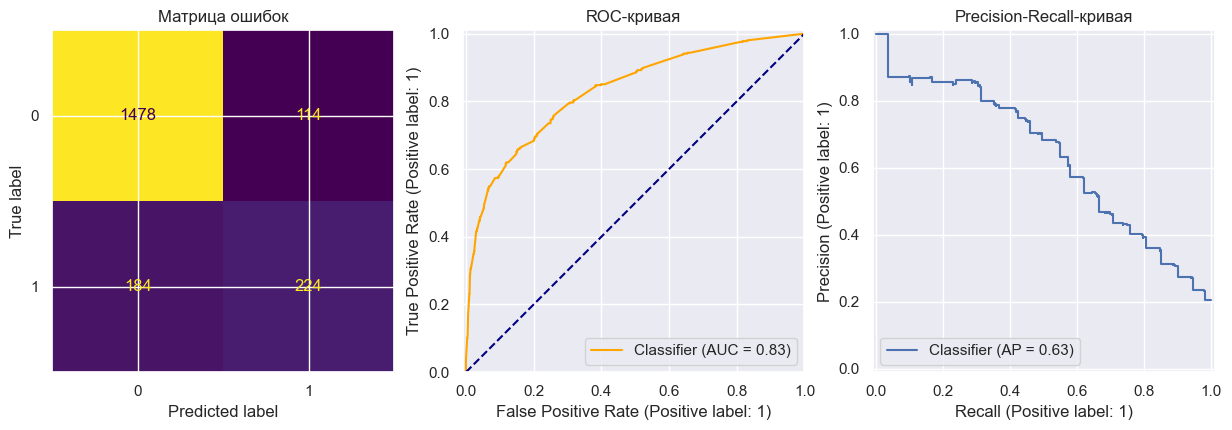

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1592
           1       0.66      0.55      0.60       408

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.75      2000
weighted avg       0.84      0.85      0.85      2000



In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    colorbar=False,
)
axes[0].set(title='Матрица ошибок')

RocCurveDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[1],
    color='orange',
)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set(title='ROC-кривая', xlim=(-0.01, 1), ylim=(0, 1.01))

PrecisionRecallDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[2],
)
axes[2].set(title='Precision-Recall-кривая')

plt.show()

print(classification_report(y_test, y_pred))

## Общие выводы

[к навигации](#Навигация)

- Рассмотрели в качестве базового классификатора DT и RF, выбрали RF
- Попробовали 2 варианта балансировки: через class_weights и upsampling. Лучше оказался upsampling
- Провели тестирование лучшей модели